# Disaster Tweets

Initial plan is to use this notebook for data exploration and preprocessing.

In [107]:
# imports

# data
import pandas as pd
import numpy as np

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# example for finding text in square brackets
# train_df.loc[train_df['text'].apply(lambda x: re.search(r'\[.*?\]', x)).isna() == False]

In [ ]:
# example for finding retweets
# train_df['text'].loc[train_df['text'].apply(lambda x: 'rt ' in x)]

### Helper function for cleaning text.

In [2]:
def text_cleaner(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\d', '', text)
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    text = tokenizer.tokenize(text)
    text = ' '.join(text)
    return text

### Helper function for normalizing text.

In [3]:
def text_normalize(text, stem_it = False, lemmatize_it = False):
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stemmer = nltk.PorterStemmer()
    lemmatizer = nltk.WordNetLemmatizer()
    text = tokenizer.tokenize(text)
    if stem_it:
        text = [stemmer.stem(word) for word in text]
    elif lemmatize_it:
        text = [lemmatizer.lemmatize(word) for word in text]
    else:
        return text
    text = ' '.join(text)
    return text

Credit for the abbreviation list below, and the function that follows: _Up-to-date list of Slangs for Text Preprocessing by @nmaguette_ (https://www.kaggle.com/nmaguette/up-to-date-slangs-conversion-for-text-processing/)

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

### Read training and test data from files.

In [4]:
# read training data
train_df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.shape

(7613, 5)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
# read test data
test_df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
test_df.shape

(3263, 4)

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### Is the target balanced?

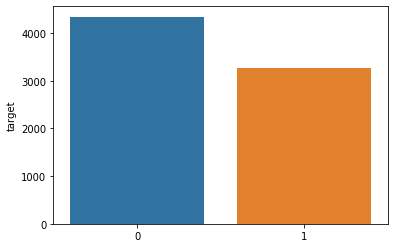

In [10]:
sns.barplot(train_df['target'].value_counts().index, train_df['target'].value_counts());

### Random sample of training and test data

In [11]:
train_df['text'].sample(5)

4197    BREAKING: Arsenal's Hector Bellerin has been a...
772     @YahooSchwab easy way to look good after the R...
3645    'Motordom' lobbied to change our language arou...
80      mom: 'we didn't get home as fast as we wished'...
6824    Hollywood movie about trapped miners released ...
Name: text, dtype: object

In [12]:
test_df['text'].sample(5)

2818    Bucket list checked 3 hours of sleep in 2 days...
2656    I'm not asking no fee to smoke sumn if we ain'...
1569                         Show no love and fear no ops
2344    Reddit Will Now Quarantine Offensive Content: ...
1436    @misschaela_ not yet.  Everywhere else except ...
Name: text, dtype: object

In [51]:
def hashtag_list(text):
    hashtags = []
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    text = tokenizer.tokenize(text)
    hashtags = [word.lower() for word in text if word.startswith('#')]
    hashtags = ', '.join(hashtags)
    return hashtags

In [52]:
train_df['hashtags'] = train_df['text'].apply(lambda x: hashtag_list(x))

In [53]:
train_df.head()

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,#earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,#wildfires
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"#alaska, #wildfires"


In [56]:
train_df['hashtags'].value_counts()

                                                  5879
#hot, #prebreak, #best                              30
#news                                               14
#gbbo                                               11
#nowplaying                                         10
                                                  ... 
#gym, #gymflow, #gymtime, #team, #assassinsû_       1
#ultimalucha                                         1
#osi2016                                             1
#directioners, #queens, #fanarmyfaceoff              1
#landslide, #skardu                                  1
Name: hashtags, Length: 1325, dtype: int64

In [59]:
def tagged_user(text):
    tagged = []
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    text = tokenizer.tokenize(text)
    tagged = [word.lower() for word in text if word.startswith('@')]
    tagged = ', '.join(tagged)
    return tagged

In [60]:
train_df['tagged_user'] = train_df['text'].apply(lambda x: tagged_user(x))

In [61]:
train_df.head()

,id,keyword,location,text,target,hashtags,tagged_user
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,#earthquake,
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,,
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,#wildfires,
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"#alaska, #wildfires",


In [62]:
train_df['tagged_user'].value_counts()

                                5628
@youtube                          62
@                                 19
@change                            9
@usatoday                          7
                                ... 
@booksbyroger                      1
@bbclaurak                         1
@ageekyfangirl14                   1
@flowri                            1
@philipduncan, @breakfastone       1
Name: tagged_user, Length: 1758, dtype: int64

In [69]:
def retweeted(text):
    retweet = 0
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    text = tokenizer.tokenize(text)
    for word in text:
        if word.lower() == 'rt':
            retweet = 1
        else:
            pass
    return retweet

In [73]:
train_df['retweet_tag'] = train_df['text'].apply(lambda x: retweeted(x))

In [77]:
train_df.head()

,id,keyword,location,text,target,hashtags,tagged_user,retweet_tag
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,#earthquake,,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,,,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,#wildfires,,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"#alaska, #wildfires",,0


In [75]:
train_df['retweet_tag'].value_counts()

0    7532
1      81
Name: retweet_tag, dtype: int64

### Clean the training data.

In [78]:
cleaned_train_df = train_df.copy()

In [79]:
cleaned_train_df['text'] = cleaned_train_df['text'].apply(lambda x: text_cleaner(x))

In [80]:
cleaned_train_df.sample(5)

,id,keyword,location,text,target,hashtags,tagged_user,retweet_tag
6849,9816,trauma,Your notifications,games that i really hope to see in agdq trauma...,0,,,0
6514,9315,survive,"Camberwell, Melbourne",i will survive by gloria gaynor with oktaviana...,1,,,0
872,1263,blood,NaN,man somebody gotta stop sbee dude too fuckin f...,0,,,0
7469,10686,wreck,NaN,car wreck,1,,@captainn_morgan,0
6028,8615,seismic,NaN,sismo detectado japìn report okinawa island re...,1,"#sismo, #japì_n, #??",,0


In [ ]:
cleaned_train_df.to_csv(path_or_buf = '/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/cleaned_train.csv',
                        index = False)

### Clean the test data.

In [81]:
cleaned_test_df = test_df.copy()

In [82]:
cleaned_test_df['text'] = cleaned_test_df['text'].apply(lambda x: text_cleaner(x))

In [83]:
cleaned_test_df.sample(5)

,id,keyword,location,text
1018,3348,demolished,Connecticut,that ball was fucking demolished
2013,6777,lightning,NaN,world war ii book lightning joe an autobiograp...
1570,5294,fear,"Jakarta, Indonesia",fear god more najib less nazir taking another ...
113,376,annihilation,NaN,i do i only get the iced annihilation
3218,10697,wreck,"San Antonio, TX",last week we had a blast hosting dinner a movi...


In [ ]:
cleaned_test_df.to_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/cleaned_test.csv',
                       index = False)

### Stemmed copy of the cleaned training data.

In [84]:
stemmed_train_df = cleaned_train_df.copy()

In [85]:
stemmed_train_df['text'] = stemmed_train_df['text'].apply(lambda x: text_normalize(x, stem_it = True))

In [86]:
stemmed_train_df.sample(5)

,id,keyword,location,text,target,hashtags,tagged_user,retweet_tag
6854,9823,trauma,"Houston, TX",photo lavenderpoetrycaf the forgotten histori ...,1,,,0
4282,6085,hellfire,Rheinbach / Germany,orchid sign of the witch,0,,,0
6274,8965,storm,Mackem in Bolton,everi time i buy a bag for life i think ive go...,0,,,0
2893,4157,drown,NaN,when you lowkey alreadi know your gonna drown ...,0,,,0
1228,1769,buildings%20burning,"Washington, D.C.",watch xela firefight struggl to save burn buil...,1,,"@chr3lyc, @iaff36",0


In [ ]:
stemmed_train_df.to_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/stemmed_train.csv',
                        index = False)

### Lemmatized copy of the cleaned training data.

In [87]:
lemmatized_train_df = cleaned_train_df.copy()

In [88]:
lemmatized_train_df['text'] = lemmatized_train_df['text'].apply(lambda x: text_normalize(x, lemmatize_it = True))

In [89]:
lemmatized_train_df.sample(5)

,id,keyword,location,text,target,hashtags,tagged_user,retweet_tag
2276,3264,demolish,NaN,ugh so hungry im going to demolish this food,0,,,0
5411,7722,panicking,NaN,all that panicking made me tired i want to sle...,1,,,0
3485,4982,explosion,NaN,i hope he doe and i hope you die in the explos...,1,,@colinhoffman29,0
1508,2176,catastrophic,"San Jose, CA",the best part of old baseball manager wearing ...,0,,,0
4384,6227,hijacker,NaN,demco hijacker wheel hitch ultra series double...,0,,,0


In [ ]:
lemmatized_train_df.to_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/lemmatized_train.csv',
                           index = False)

### Missing keyword and location entries.

Replace missing keyword and location information with 'no_keyword' and 'no_location' respectively.

In [ ]:
dummied_train_df = cleaned_train_df.copy()

In [ ]:
no_keyword = dummied_train_df.loc[dummied_train_df['keyword'].isna() == True].index
dummied_train_df['keyword'].loc[no_keyword] = 'no_keyword'

In [ ]:
no_location = dummied_train_df.loc[dummied_train_df['location'].isna() == True].index
dummied_train_df['location'].loc[no_location] = 'no_location'

In [ ]:
dummied_train_df.info()

In [ ]:
dummied_train_df.head()

Commented out testing data changes; won't mess with testing data until final decsion of training data treatment.

In [ ]:
# test_df.info()

In [ ]:
# no_keyword = test_df.loc[test_df['keyword'].isna() == True].index
# test_df['keyword'].loc[no_keyword] = 'no_keyword'

In [ ]:
# no_location = test_df.loc[test_df['location'].isna() == True].index
# test_df['location'].loc[no_location] = 'no_location'

In [ ]:
# test_df.info()

In [ ]:
# test_df.head()